In [1]:
# Instalação das bibliotecas necessárias
# Execute no terminal: pip install google-analytics-data pandas matplotlib seaborn plotly

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from google.analytics.data_v1beta import BetaAnalyticsDataClient
from google.analytics.data_v1beta.types import DateRange, Dimension, Metric, RunReportRequest
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configuração de estilo para os gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# Configuração da autenticação com Google Analytics
# Você precisa ter um arquivo de credenciais JSON baixado do Google Cloud Console

def setup_analytics_client(credentials_path):
    """
    Configura o cliente do Google Analytics com as credenciais fornecidas.
    
    Args:
        credentials_path (str): Caminho para o arquivo JSON de credenciais
    
    Returns:
        BetaAnalyticsDataClient: Cliente configurado para fazer requisições
    """
    import os
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credentials_path
    client = BetaAnalyticsDataClient()
    return client

# Configurar o cliente (substitua pelo caminho do seu arquivo de credenciais)
# client = setup_analytics_client('path/to/your/credentials.json')


In [3]:
def extract_ga_data(client, property_id, start_date, end_date, dimensions, metrics):
    """
    Extrai dados do Google Analytics usando a API GA4.
    
    Args:
        client: Cliente autenticado do Google Analytics
        property_id (str): ID da propriedade do GA4
        start_date (str): Data de início no formato 'YYYY-MM-DD'
        end_date (str): Data de fim no formato 'YYYY-MM-DD'
        dimensions (list): Lista de dimensões para extrair
        metrics (list): Lista de métricas para extrair
    
    Returns:
        pandas.DataFrame: DataFrame com os dados extraídos
    """
    request = RunReportRequest(
        property=f"properties/{property_id}",
        dimensions=[Dimension(name=dim) for dim in dimensions],
        metrics=[Metric(name=metric) for metric in metrics],
        date_ranges=[DateRange(start_date=start_date, end_date=end_date)],
    )
    
    response = client.run_report(request)
    
    # Processar a resposta em um DataFrame
    data = []
    for row in response.rows:
        row_data = {}
        for i, dimension in enumerate(dimensions):
            row_data[dimension] = row.dimension_values[i].value
        for i, metric in enumerate(metrics):
            row_data[metrics[i]] = float(row.metric_values[i].value)
        data.append(row_data)
    
    return pd.DataFrame(data)



In [4]:
# Exemplo de extração de dados (adapte conforme sua necessidade)
def load_sample_data():
    """
    Para este tutorial, vamos criar dados de exemplo que simulam dados reais do GA.
    Em um cenário real, você usaria a função extract_ga_data().
    """
    
    # Criando dados de exemplo para demonstração
    dates = pd.date_range('2024-01-01', '2024-12-31', freq='D')
    np.random.seed(42)
    
    # Dados de tráfego diário
    traffic_data = pd.DataFrame({
        'date': dates,
        'sessions': np.random.poisson(1000, len(dates)) + np.sin(np.arange(len(dates)) * 2 * np.pi / 7) * 200,
        'users': np.random.poisson(800, len(dates)) + np.sin(np.arange(len(dates)) * 2 * np.pi / 7) * 150,
        'pageViews': np.random.poisson(3000, len(dates)) + np.sin(np.arange(len(dates)) * 2 * np.pi / 7) * 500,
        'bounceRate': np.random.beta(2, 3, len(dates)),
        'avgSessionDuration': np.random.gamma(2, 120, len(dates))
    })
    
    # Dados de canais de aquisição
    channels = ['Organic Search', 'Direct', 'Social Media', 'Paid Search', 'Email', 'Referral']
    channel_data = pd.DataFrame({
        'channel': channels,
        'sessions': np.random.poisson([3000, 2500, 1500, 2000, 800, 1200]),
        'users': np.random.poisson([2400, 2000, 1200, 1600, 640, 960]),
        'conversions': np.random.poisson([150, 120, 60, 180, 80, 40])
    })
    
    # Dados de dispositivos
    devices = ['Desktop', 'Mobile', 'Tablet']
    device_data = pd.DataFrame({
        'device': devices,
        'sessions': [4500, 6800, 1200],
        'bounceRate': [0.45, 0.52, 0.48],
        'conversionRate': [0.032, 0.028, 0.035]
    })
    
    # Dados de páginas mais visitadas
    pages = ['/home', '/produtos', '/sobre', '/contato', '/blog', '/categoria-a', '/categoria-b', '/checkout']
    page_data = pd.DataFrame({
        'page': pages,
        'pageViews': np.random.poisson([8000, 3500, 1200, 800, 2200, 1800, 1500, 600]),
        'uniquePageViews': np.random.poisson([6000, 2800, 1000, 650, 1800, 1400, 1200, 450]),
        'avgTimeOnPage': np.random.gamma(2, 60, len(pages)),
        'exitRate': np.random.beta(2, 8, len(pages))
    })
    
    return traffic_data, channel_data, device_data, page_data

# Carregar os dados
traffic_df, channel_df, device_df, page_df = load_sample_data()

In [12]:
print(traffic_df)
print(channel_df)
print(device_df)
print(page_df )

          date     sessions       users    pageViews  bounceRate  \
0   2024-01-01   988.000000  806.000000  2942.000000    0.469488   
1   2024-01-02  1178.366296  883.274722  3365.915741    0.222797   
2   2024-01-03  1157.985582  946.239187  3509.463956    0.492311   
3   2024-01-04  1095.776748  811.082561  3146.941870    0.432403   
4   2024-01-05   948.223252  708.917439  2879.058130    0.559826   
..         ...          ...         ...          ...         ...   
361 2024-12-27   936.223252  695.917439  2748.058130    0.552958   
362 2024-12-28   778.014418  643.760813  2556.536044    0.669206   
363 2024-12-29   804.633704  718.725278  2611.084259    0.716130   
364 2024-12-30  1000.000000  826.000000  3012.000000    0.187743   
365 2024-12-31  1209.366296  869.274722  3449.915741    0.546048   

     avgSessionDuration  day_number  sessions_ma7  sessions_ma30  
0            588.336306           0           NaN            NaN  
1             86.372073           1           NaN

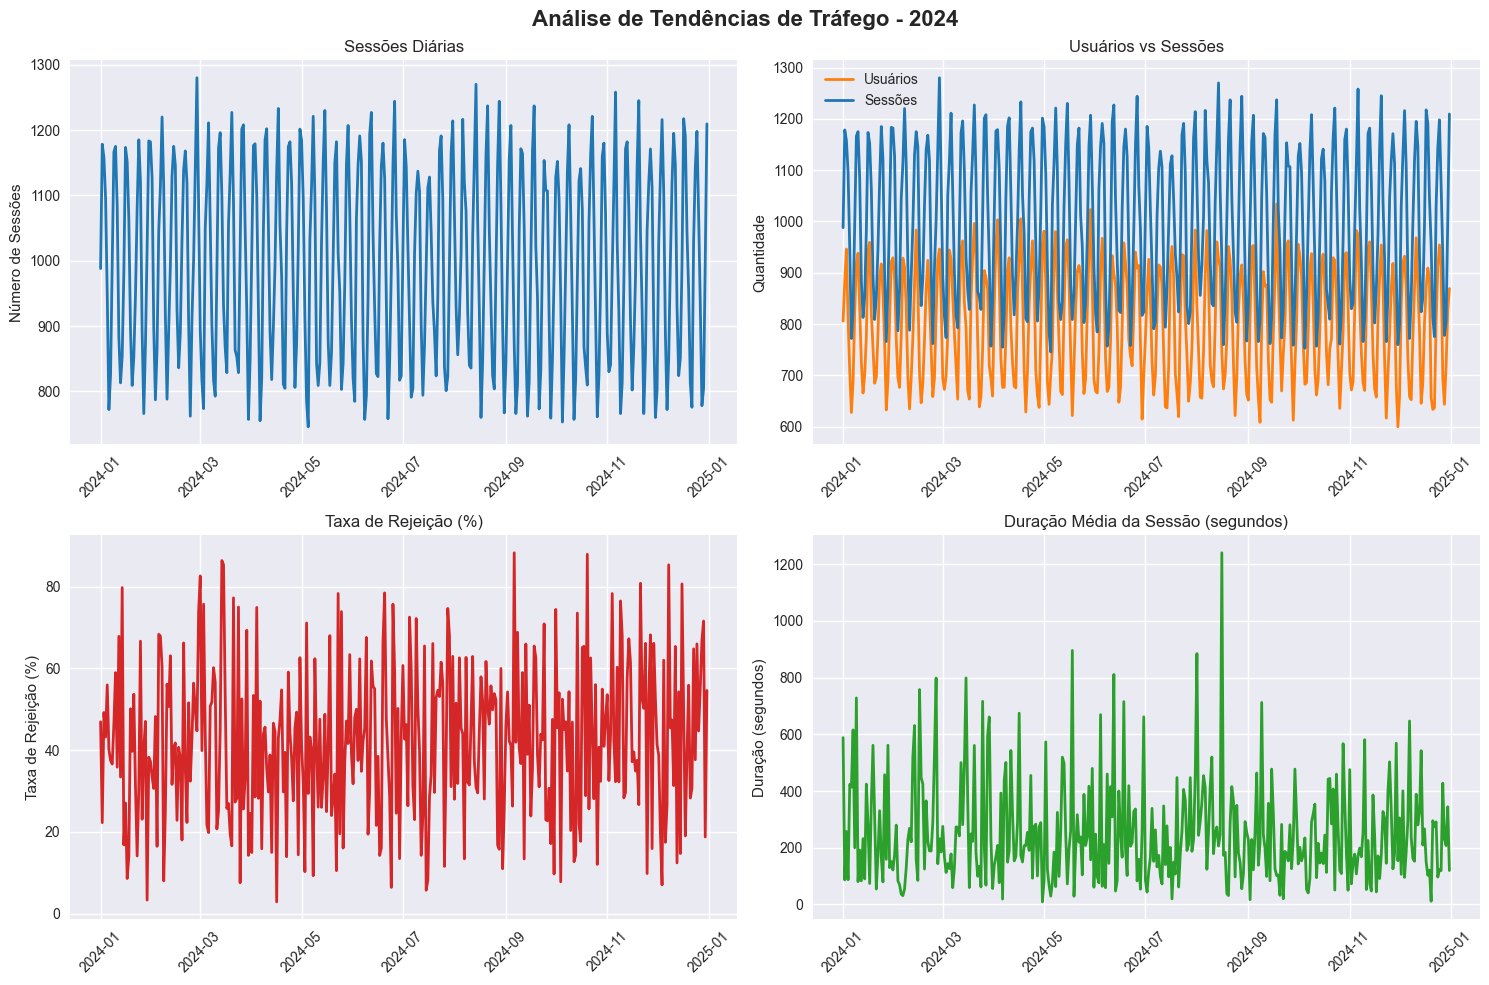

In [5]:
# Criando um gráfico de tendência temporal do tráfego
def plot_traffic_trends(traffic_df):
    """
    Cria visualizações das tendências de tráfego ao longo do tempo.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Análise de Tendências de Tráfego - 2024', fontsize=16, fontweight='bold')
    
    # Gráfico 1: Sessões ao longo do tempo
    axes[0, 0].plot(traffic_df['date'], traffic_df['sessions'], color='#1f77b4', linewidth=2)
    axes[0, 0].set_title('Sessões Diárias')
    axes[0, 0].set_ylabel('Número de Sessões')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Gráfico 2: Usuários vs Sessões
    axes[0, 1].plot(traffic_df['date'], traffic_df['users'], label='Usuários', color='#ff7f0e', linewidth=2)
    axes[0, 1].plot(traffic_df['date'], traffic_df['sessions'], label='Sessões', color='#1f77b4', linewidth=2)
    axes[0, 1].set_title('Usuários vs Sessões')
    axes[0, 1].set_ylabel('Quantidade')
    axes[0, 1].legend()
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Gráfico 3: Taxa de rejeição
    axes[1, 0].plot(traffic_df['date'], traffic_df['bounceRate'] * 100, color='#d62728', linewidth=2)
    axes[1, 0].set_title('Taxa de Rejeição (%)')
    axes[1, 0].set_ylabel('Taxa de Rejeição (%)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Gráfico 4: Duração média da sessão
    axes[1, 1].plot(traffic_df['date'], traffic_df['avgSessionDuration'], color='#2ca02c', linewidth=2)
    axes[1, 1].set_title('Duração Média da Sessão (segundos)')
    axes[1, 1].set_ylabel('Duração (segundos)')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Executar a análise de tendências
plot_traffic_trends(traffic_df)

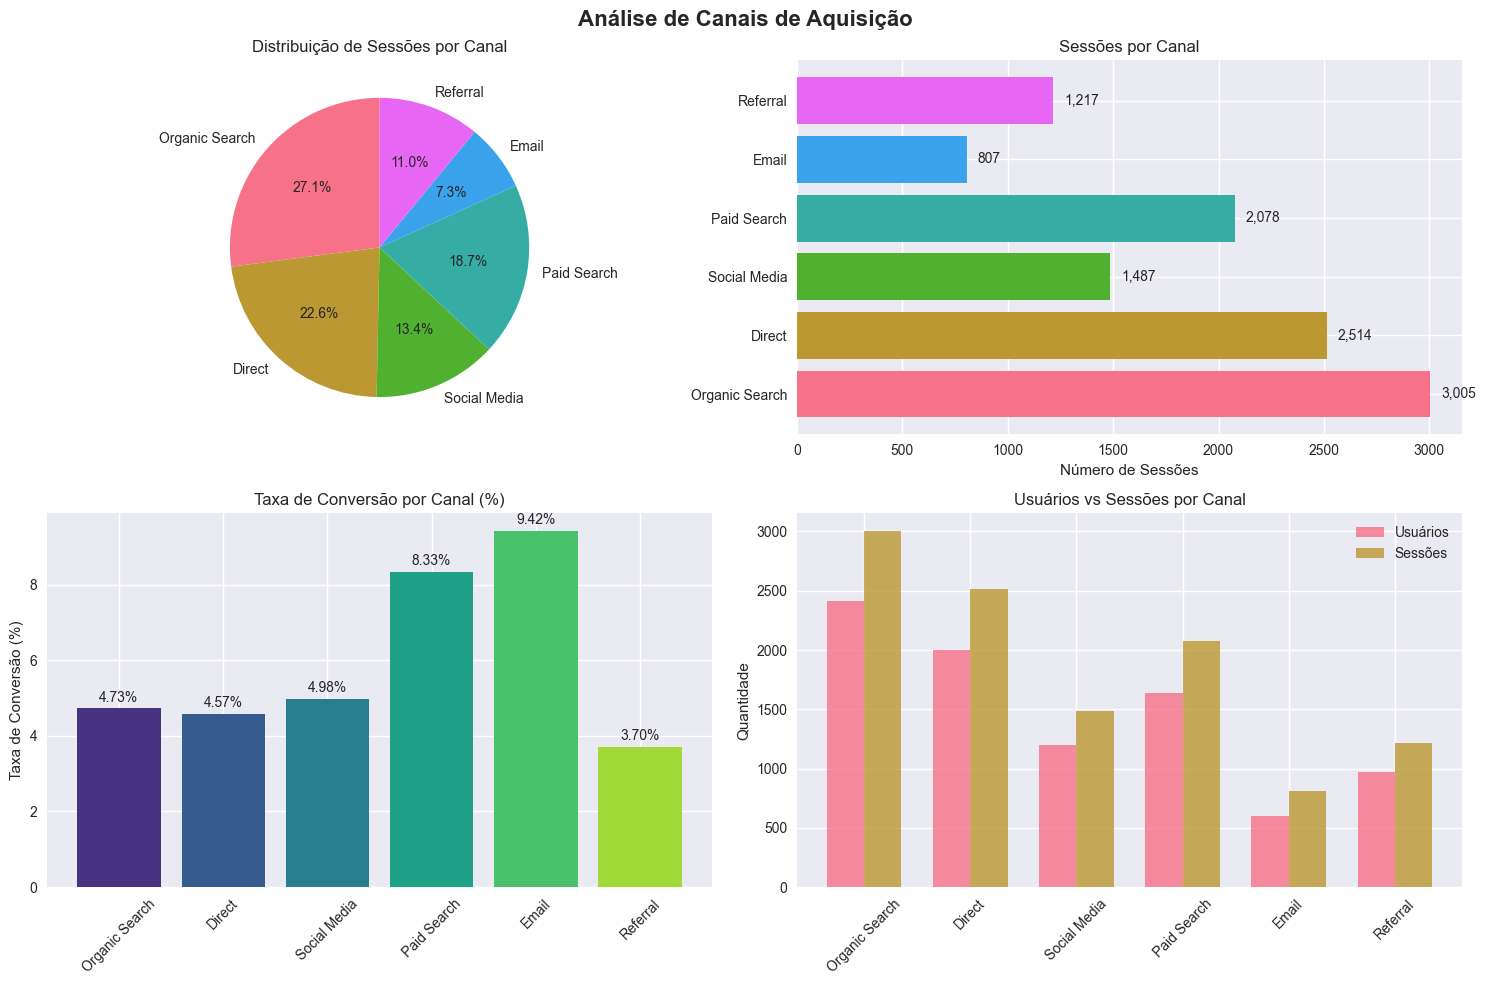

In [ ]:
# Análise detalhada dos canais de aquisição de tráfego
def plot_acquisition_analysis(channel_df):
    """
    Cria visualizações para análise dos canais de aquisição.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Análise de Canais de Aquisição', fontsize=16, fontweight='bold')
    
    # Gráfico 1: Distribuição de sessões por canal (Pizza)
    axes[0, 0].pie(channel_df['sessions'], labels=channel_df['channel'], autopct='%1.1f%%', startangle=90)
    axes[0, 0].set_title('Distribuição de Sessões por Canal')
    
    # Gráfico 2: Sessões por canal (Barras horizontais)
    bars = axes[0, 1].barh(channel_df['channel'], channel_df['sessions'], color=sns.color_palette("husl", len(channel_df)))
    axes[0, 1].set_title('Sessões por Canal')
    axes[0, 1].set_xlabel('Número de Sessões')
    
    # Adicionar valores nas barras
    for i, bar in enumerate(bars):
        width = bar.get_width()
        axes[0, 1].text(width + 50, bar.get_y() + bar.get_height()/2, 
                       f'{int(width):,}', ha='left', va='center')
    
    # Gráfico 3: Taxa de conversão por canal
    channel_df['conversionRate'] = (channel_df['conversions'] / channel_df['sessions']) * 100
    bars = axes[1, 0].bar(channel_df['channel'], channel_df['conversionRate'], 
                         color=sns.color_palette("viridis", len(channel_df)))
    axes[1, 0].set_title('Taxa de Conversão por Canal (%)')
    axes[1, 0].set_ylabel('Taxa de Conversão (%)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Adicionar valores nas barras
    for i, bar in enumerate(bars):
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2, height + 0.1,
                       f'{height:.2f}%', ha='center', va='bottom')
    
    # Gráfico 4: Comparação Usuários vs Sessões por canal
    x = np.arange(len(channel_df['channel']))
    width = 0.35
    
    bars1 = axes[1, 1].bar(x - width/2, channel_df['users'], width, label='Usuários', alpha=0.8)
    bars2 = axes[1, 1].bar(x + width/2, channel_df['sessions'], width, label='Sessões', alpha=0.8)
    
    axes[1, 1].set_title('Usuários vs Sessões por Canal')
    axes[1, 1].set_ylabel('Quantidade')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(channel_df['channel'], rotation=45)
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Criar um gráfico interativo com Plotly
    fig_plotly = go.Figure()
    
    fig_plotly.add_trace(go.Scatter(
        x=channel_df['sessions'],
        y=channel_df['conversionRate'],
        mode='markers+text',
        text=channel_df['channel'],
        textposition="top center",
        marker=dict(size=channel_df['users']/50, 
                   color=channel_df['conversions'],
                   colorscale='Viridis',
                   showscale=True,
                   colorbar=dict(title="Conversões")),
        name='Canais'
    ))
    
    fig_plotly.update_layout(
        title='Análise Bubble Chart: Sessões vs Taxa de Conversão<br><sub>Tamanho da bolha = Usuários | Cor = Conversões</sub>',
        xaxis_title='Número de Sessões',
        yaxis_title='Taxa de Conversão (%)',
        width=800,
        height=600
    )
    #fig_plotly.write_html('D:/Downloads/imagem3.html')
    fig_plotly.show()

# Executar análise de canais
plot_acquisition_analysis(channel_df)

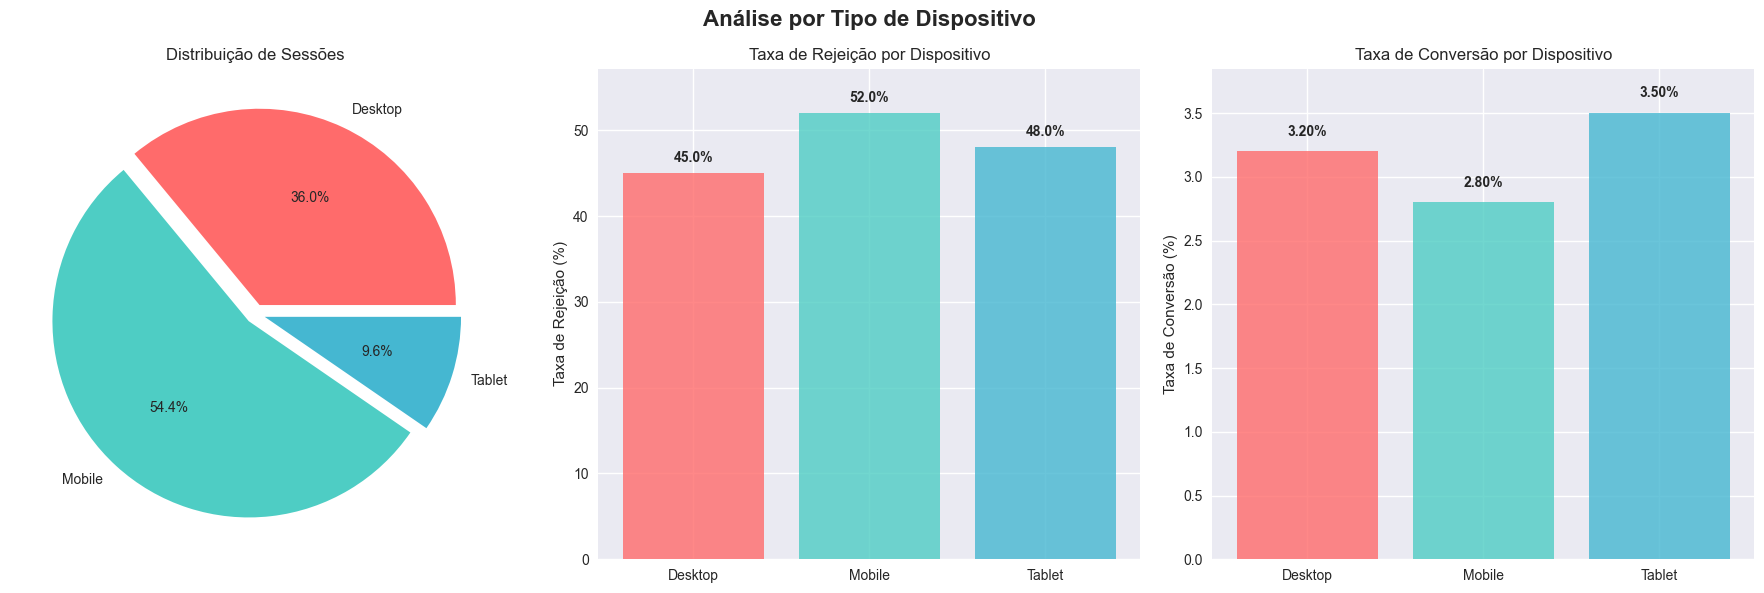


📊 RESUMO ANALÍTICO POR DISPOSITIVO

🔹 DESKTOP
   • Participação: 36.0% (4,500 sessões)
   • Taxa de Rejeição: 45.0%
   • Taxa de Conversão: 3.20%
   • Avaliação Rejeição: ⚠️ Boa
   • Avaliação Conversão: ✅ Excelente

🔹 MOBILE
   • Participação: 54.4% (6,800 sessões)
   • Taxa de Rejeição: 52.0%
   • Taxa de Conversão: 2.80%
   • Avaliação Rejeição: ⚠️ Boa
   • Avaliação Conversão: ⚠️ Boa

🔹 TABLET
   • Participação: 9.6% (1,200 sessões)
   • Taxa de Rejeição: 48.0%
   • Taxa de Conversão: 3.50%
   • Avaliação Rejeição: ⚠️ Boa
   • Avaliação Conversão: ✅ Excelente


In [7]:
# Análise do comportamento por tipo de dispositivo
def plot_device_analysis(device_df):
    """
    Analisa o comportamento dos usuários por tipo de dispositivo.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Análise por Tipo de Dispositivo', fontsize=16, fontweight='bold')
    
    # Gráfico 1: Distribuição de sessões por dispositivo
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    wedges, texts, autotexts = axes[0].pie(device_df['sessions'], 
                                          labels=device_df['device'], 
                                          autopct='%1.1f%%',
                                          colors=colors,
                                          explode=[0.05, 0.05, 0.05])
    axes[0].set_title('Distribuição de Sessões')
    
    # Gráfico 2: Taxa de rejeição por dispositivo
    bars = axes[1].bar(device_df['device'], device_df['bounceRate'] * 100, color=colors, alpha=0.8)
    axes[1].set_title('Taxa de Rejeição por Dispositivo')
    axes[1].set_ylabel('Taxa de Rejeição (%)')
    axes[1].set_ylim(0, max(device_df['bounceRate'] * 100) * 1.1)
    
    # Adicionar valores nas barras
    for i, bar in enumerate(bars):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2, height + 1,
                    f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # Gráfico 3: Taxa de conversão por dispositivo
    bars = axes[2].bar(device_df['device'], device_df['conversionRate'] * 100, color=colors, alpha=0.8)
    axes[2].set_title('Taxa de Conversão por Dispositivo')
    axes[2].set_ylabel('Taxa de Conversão (%)')
    axes[2].set_ylim(0, max(device_df['conversionRate'] * 100) * 1.1)
    
    # Adicionar valores nas barras
    for i, bar in enumerate(bars):
        height = bar.get_height()
        axes[2].text(bar.get_x() + bar.get_width()/2, height + 0.1,
                    f'{height:.2f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Criar tabela resumo
    print("\n📊 RESUMO ANALÍTICO POR DISPOSITIVO")
    print("=" * 50)
    
    total_sessions = device_df['sessions'].sum()
    
    for _, row in device_df.iterrows():
        device = row['device']
        sessions = row['sessions']
        bounce_rate = row['bounceRate'] * 100
        conversion_rate = row['conversionRate'] * 100
        share = (sessions / total_sessions) * 100
        
        print(f"\n🔹 {device.upper()}")
        print(f"   • Participação: {share:.1f}% ({sessions:,} sessões)")
        print(f"   • Taxa de Rejeição: {bounce_rate:.1f}%")
        print(f"   • Taxa de Conversão: {conversion_rate:.2f}%")
        
        # Análise qualitativa
        if bounce_rate < 45:
            bounce_status = "✅ Excelente"
        elif bounce_rate < 55:
            bounce_status = "⚠️ Boa"
        else:
            bounce_status = "❌ Precisa melhorar"
            
        if conversion_rate > 3:
            conv_status = "✅ Excelente"
        elif conversion_rate > 2:
            conv_status = "⚠️ Boa"
        else:
            conv_status = "❌ Precisa melhorar"
            
        print(f"   • Avaliação Rejeição: {bounce_status}")
        print(f"   • Avaliação Conversão: {conv_status}")

# Executar análise de dispositivos
plot_device_analysis(device_df)

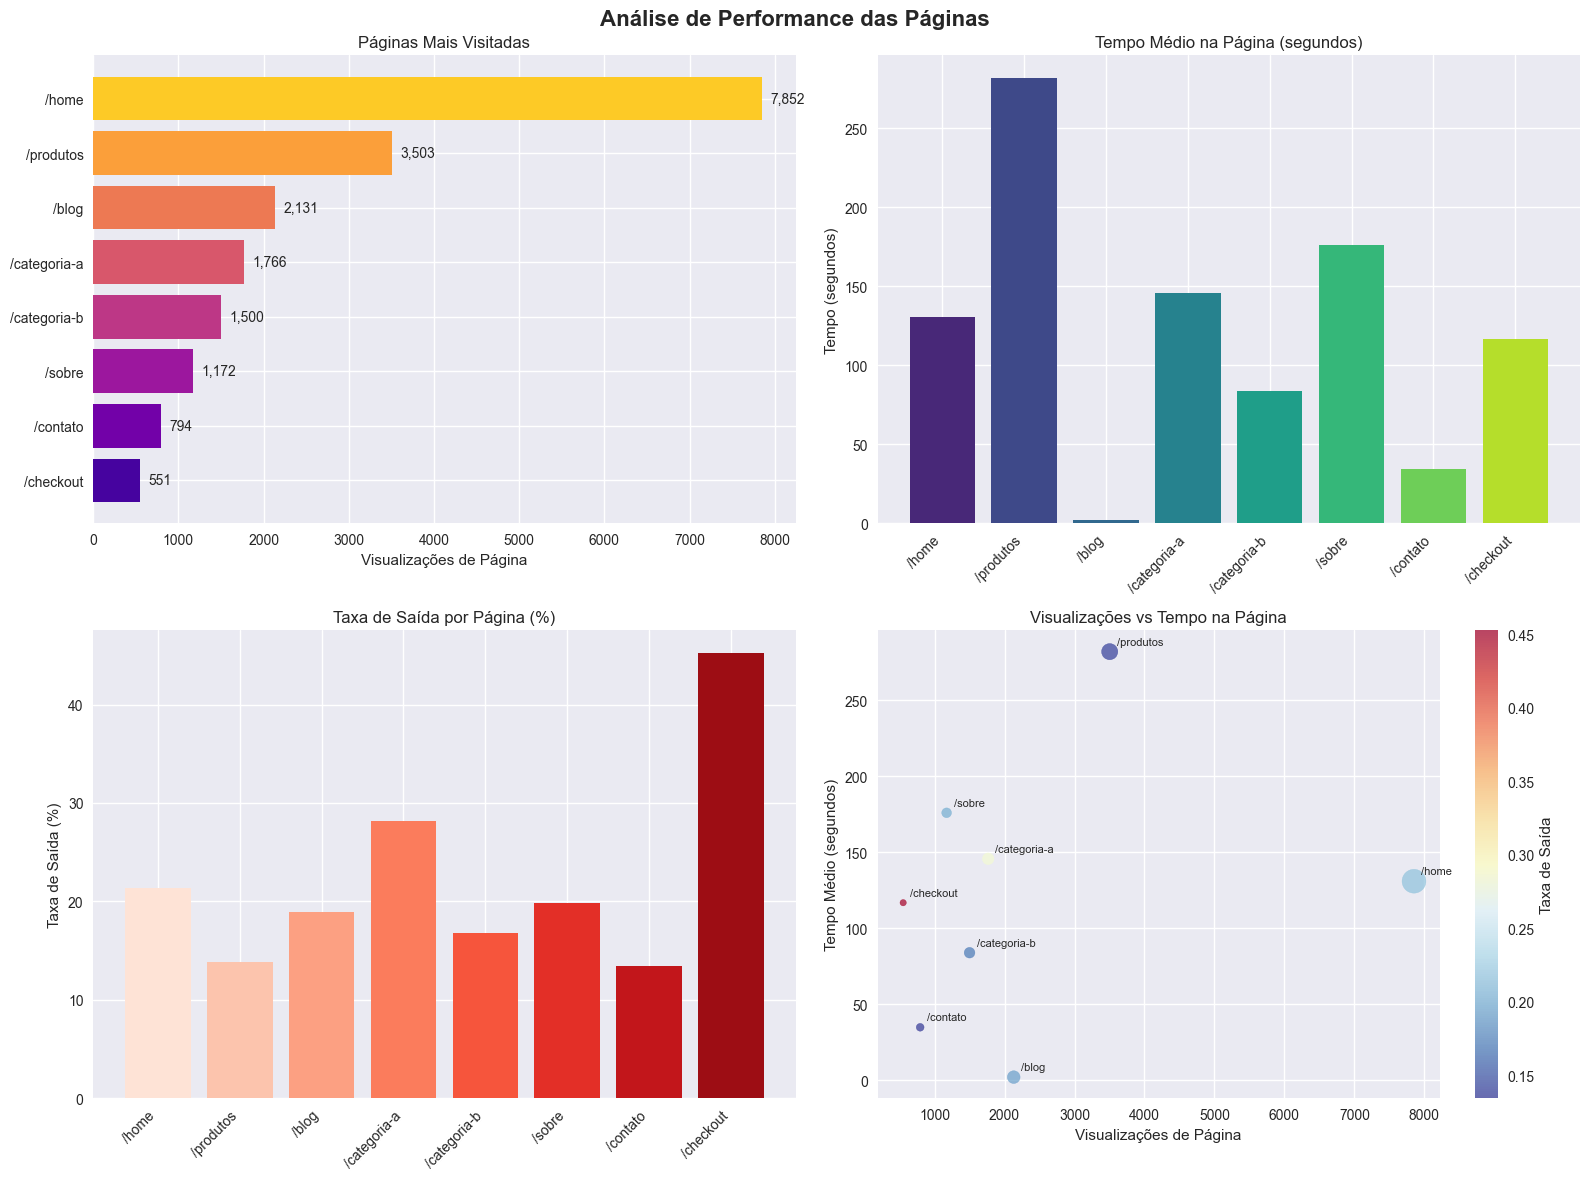

In [ ]:
# Análise detalhada da performance das páginas do site
def plot_page_performance(page_df):
    """
    Analisa a performance das diferentes páginas do site.
    """
    # Preparar dados
    page_df = page_df.sort_values('pageViews', ascending=False)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Análise de Performance das Páginas', fontsize=16, fontweight='bold')
    
    # Gráfico 1: Top páginas por visualizações
    bars = axes[0, 0].barh(page_df['page'][::-1], page_df['pageViews'][::-1], 
                          color=sns.color_palette("plasma", len(page_df)))
    axes[0, 0].set_title('Páginas Mais Visitadas')
    axes[0, 0].set_xlabel('Visualizações de Página')
    
    # Adicionar valores
    for i, bar in enumerate(bars):
        width = bar.get_width()
        axes[0, 0].text(width + 100, bar.get_y() + bar.get_height()/2,
                       f'{int(width):,}', ha='left', va='center')
    
    # Gráfico 2: Tempo médio na página
    bars = axes[0, 1].bar(range(len(page_df)), page_df['avgTimeOnPage'], 
                         color=sns.color_palette("viridis", len(page_df)))
    axes[0, 1].set_title('Tempo Médio na Página (segundos)')
    axes[0, 1].set_ylabel('Tempo (segundos)')
    axes[0, 1].set_xticks(range(len(page_df)))
    axes[0, 1].set_xticklabels(page_df['page'], rotation=45, ha='right')
    
    # Gráfico 3: Taxa de saída por página
    bars = axes[1, 0].bar(range(len(page_df)), page_df['exitRate'] * 100,
                         color=sns.color_palette("Reds", len(page_df)))
    axes[1, 0].set_title('Taxa de Saída por Página (%)')
    axes[1, 0].set_ylabel('Taxa de Saída (%)')
    axes[1, 0].set_xticks(range(len(page_df)))
    axes[1, 0].set_xticklabels(page_df['page'], rotation=45, ha='right')
    
    # Gráfico 4: Scatter plot - Visualizações vs Tempo na Página
    scatter = axes[1, 1].scatter(page_df['pageViews'], page_df['avgTimeOnPage'],
                                s=page_df['uniquePageViews']/20,
                                c=page_df['exitRate'], cmap='RdYlBu_r',
                                alpha=0.7)
    axes[1, 1].set_title('Visualizações vs Tempo na Página')
    axes[1, 1].set_xlabel('Visualizações de Página')
    axes[1, 1].set_ylabel('Tempo Médio (segundos)')
    
    # Adicionar labels dos pontos
    for i, page in enumerate(page_df['page']):
        axes[1, 1].annotate(page, (page_df['pageViews'].iloc[i], page_df['avgTimeOnPage'].iloc[i]),
                           xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # Adicionar colorbar
    cbar = plt.colorbar(scatter, ax=axes[1, 1])
    cbar.set_label('Taxa de Saída')
    
    plt.tight_layout()
    plt.show()
    
    # Criar gráfico interativo com Plotly
    fig_interactive = px.treemap(
        page_df,
        path=['page'],
        values='pageViews',
        color='avgTimeOnPage',
        color_continuous_scale='Viridis',
        title='Mapa de Calor: Visualizações vs Tempo na Página'
    )
    
    fig_interactive.update_layout(width=800, height=600)
    #fig_interactive.write_html('D:/Downloads/imagem6.html')
    fig_interactive.show()

# Executar análise de páginas
plot_page_performance(page_df)

In [19]:
# Criando um dashboard executivo com métricas principais
def create_executive_dashboard(traffic_df, channel_df, device_df):
    """
    Cria um dashboard executivo com as principais métricas de forma interativa.
    """
    
    # Calcular KPIs principais
    total_sessions = traffic_df['sessions'].sum()
    total_users = traffic_df['users'].sum()
    avg_bounce_rate = traffic_df['bounceRate'].mean() * 100
    avg_session_duration = traffic_df['avgSessionDuration'].mean()
    
    # Criar subplots
    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=('Evolução Mensal do Tráfego', 'Distribuição por Canal',
                       'Performance por Dispositivo', 'Métricas de Qualidade',
                       'Tendência de Sessões (7 dias)', 'Funil de Conversão'),
        specs=[[{"secondary_y": True}, {"type": "pie"}],
               [{"type": "bar"}, {"type": "scatter"}],
               [{"secondary_y": True}, {"type": "funnel"}]]
    )
    
    # Gráfico 1: Evolução mensal (agregando dados diários em mensais)
    traffic_monthly = traffic_df.copy()
    traffic_monthly['month'] = traffic_monthly['date'].dt.to_period('M')
    monthly_data = traffic_monthly.groupby('month').agg({
        'sessions': 'sum',
        'users': 'sum',
        'bounceRate': 'mean'
    }).reset_index()
    
    fig.add_trace(
        go.Scatter(x=monthly_data['month'].astype(str), y=monthly_data['sessions'],
                  name='Sessões', line=dict(color='#1f77b4')),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Scatter(x=monthly_data['month'].astype(str), y=monthly_data['bounceRate']*100,
                  name='Taxa Rejeição (%)', line=dict(color='#ff7f0e')),
        row=1, col=1, secondary_y=True
    )
    
    # Gráfico 2: Pizza dos canais
    fig.add_trace(
        go.Pie(labels=channel_df['channel'], values=channel_df['sessions'],
               name="Canais"),
        row=1, col=2
    )
    
    # Gráfico 3: Performance por dispositivo
    fig.add_trace(
        go.Bar(x=device_df['device'], y=device_df['sessions'],
               name='Sessões por Dispositivo', marker_color='lightblue'),
        row=2, col=1
    )
    
    # Gráfico 4: Scatter métricas de qualidade
    fig.add_trace(
        go.Scatter(x=channel_df['sessions'], y=channel_df['conversions'],
                  mode='markers+text', text=channel_df['channel'],
                  textposition="top center", name='Canais',
                  marker=dict(size=10, color='red')),
        row=2, col=2
    )
    
    # Gráfico 5: Tendência últimos 7 dias
    last_7_days = traffic_df.tail(7)
    fig.add_trace(
        go.Scatter(x=last_7_days['date'], y=last_7_days['sessions'],
                  mode='lines+markers', name='Últimos 7 dias',
                  line=dict(color='green', width=3)),
        row=3, col=1
    )
    
    # Gráfico 6: Funil simples
    funnel_data = ['Visitantes', 'Sessões Engajadas', 'Conversões']
    funnel_values = [total_users, total_sessions*0.6, total_sessions*0.03]
    
    fig.add_trace(
        go.Funnel(y=funnel_data, x=funnel_values, name='Funil'),
        row=3, col=2
    )
    
    # Atualizar layout
    fig.update_layout(
        title_text="📊 Dashboard Executivo - Google Analytics",
        title_x=0.5,
        showlegend=False,
        height=900,
        width=1200
    )
    
    # Mostrar dashboard
    fig.write_html('D:/Downloads/imagem7.html')
    fig.show()
    
    # Imprimir KPIs principais
    print("\n" + "="*60)
    print("📈 RESUMO EXECUTIVO - PRINCIPAIS KPIS")
    print("="*60)
    print(f"🔹 Total de Sessões: {total_sessions:,.0f}")
    print(f"🔹 Total de Usuários: {total_users:,.0f}")
    print(f"🔹 Taxa de Rejeição Média: {avg_bounce_rate:.1f}%")
    print(f"🔹 Duração Média da Sessão: {avg_session_duration:.0f} segundos")
    print(f"🔹 Páginas por Sessão: {traffic_df['pageViews'].sum() / total_sessions:.1f}")
    
    # Canal com melhor performance
    best_channel = channel_df.loc[channel_df['conversionRate'].idxmax()]
    print(f"🔹 Melhor Canal (Conversão): {best_channel['channel']} ({best_channel['conversionRate']:.2f}%)")
    
    # Dispositivo dominante
    main_device = device_df.loc[device_df['sessions'].idxmax()]
    print(f"🔹 Dispositivo Principal: {main_device['device']} ({main_device['sessions']:,} sessões)")
    
    print("="*60)

# Executar dashboard executivo
create_executive_dashboard(traffic_df, channel_df, device_df)


📈 RESUMO EXECUTIVO - PRINCIPAIS KPIS
🔹 Total de Sessões: 365,041
🔹 Total de Usuários: 292,979
🔹 Taxa de Rejeição Média: 42.2%
🔹 Duração Média da Sessão: 251 segundos
🔹 Páginas por Sessão: 3.0
🔹 Melhor Canal (Conversão): Email (9.42%)
🔹 Dispositivo Principal: Mobile (6,800 sessões)


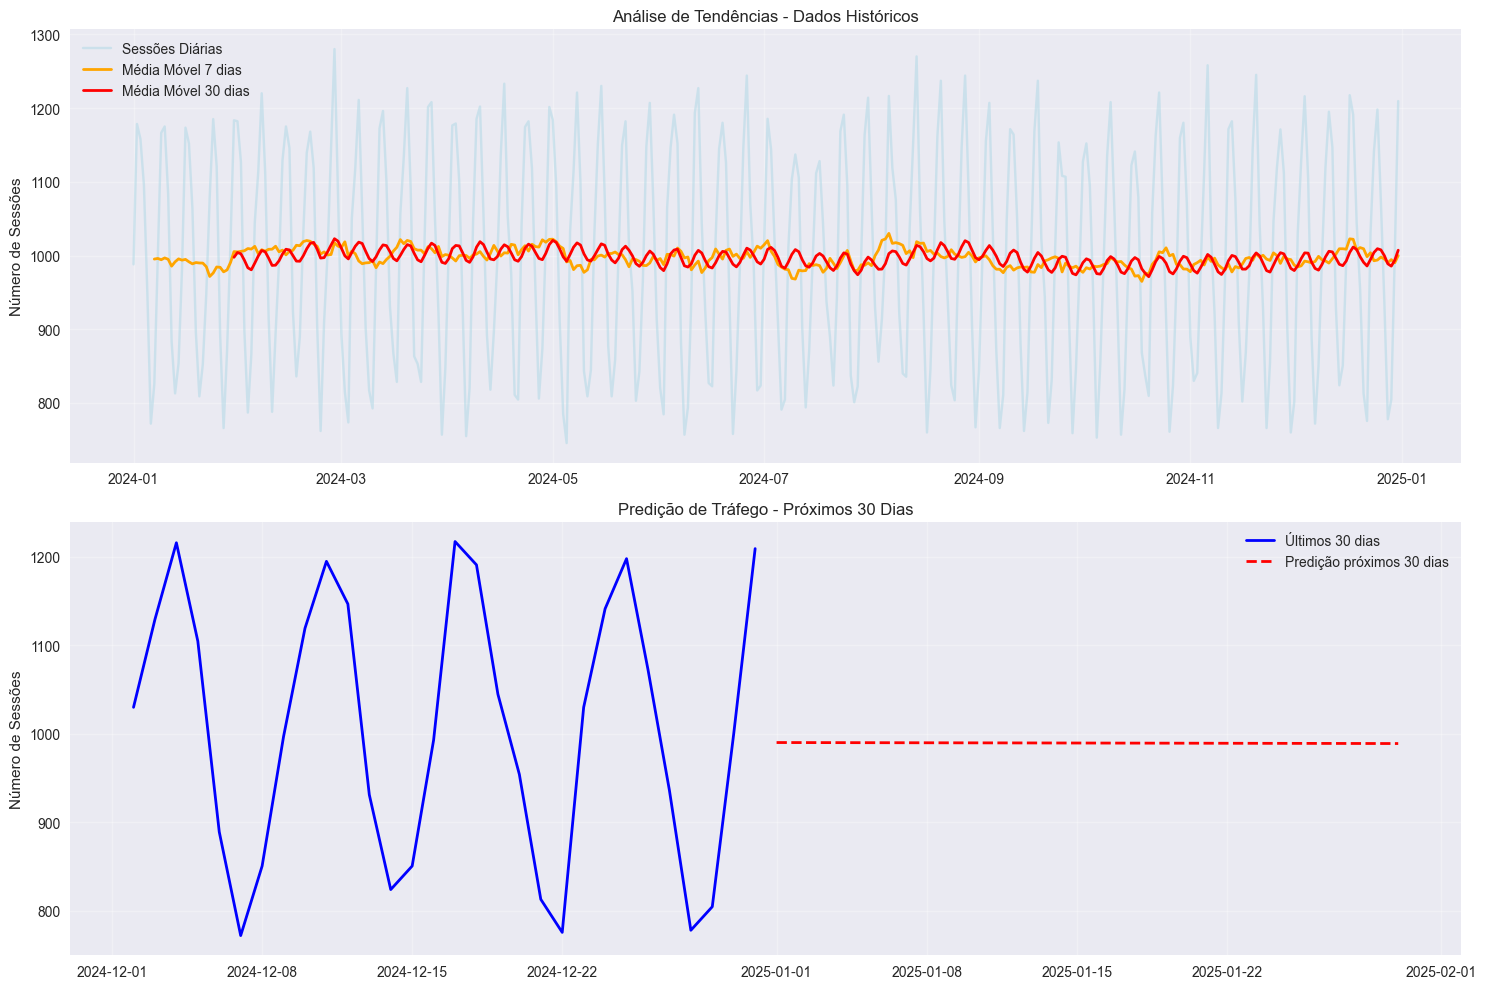


🔮 ANÁLISE PREDITIVA
📊 Média atual (últimos 30 dias): 1007 sessões/dia
📈 Média prevista (próximos 30 dias): 990 sessões/dia
📊 Taxa de crescimento prevista: -1.7%
🎯 ➡️ Tendência ESTÁVEL


In [10]:
# Análise preditiva simples usando médias móveis
def predictive_analysis(traffic_df):
    """
    Realiza análise preditiva básica para prever tendências futuras.
    """
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import PolynomialFeatures
    
    # Preparar dados para predição
    traffic_df['day_number'] = range(len(traffic_df))
    
    # Criar médias móveis
    traffic_df['sessions_ma7'] = traffic_df['sessions'].rolling(window=7).mean()
    traffic_df['sessions_ma30'] = traffic_df['sessions'].rolling(window=30).mean()
    
    # Modelo de regressão linear para tendência
    X = traffic_df['day_number'].values.reshape(-1, 1)
    y = traffic_df['sessions'].values
    
    model = LinearRegression()
    model.fit(X, y)
    
    # Predições para próximos 30 dias
    future_days = np.arange(len(traffic_df), len(traffic_df) + 30).reshape(-1, 1)
    future_predictions = model.predict(future_days)
    
    # Criar gráfico de predição
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Gráfico 1: Dados históricos com médias móveis
    ax1.plot(traffic_df['date'], traffic_df['sessions'], 
             label='Sessões Diárias', alpha=0.5, color='lightblue')
    ax1.plot(traffic_df['date'], traffic_df['sessions_ma7'], 
             label='Média Móvel 7 dias', color='orange', linewidth=2)
    ax1.plot(traffic_df['date'], traffic_df['sessions_ma30'], 
             label='Média Móvel 30 dias', color='red', linewidth=2)
    ax1.set_title('Análise de Tendências - Dados Históricos')
    ax1.set_ylabel('Número de Sessões')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Gráfico 2: Predição
    last_30_days = traffic_df.tail(30)
    future_dates = pd.date_range(start=traffic_df['date'].iloc[-1] + timedelta(days=1), 
                                periods=30, freq='D')
    
    ax2.plot(last_30_days['date'], last_30_days['sessions'], 
             label='Últimos 30 dias', color='blue', linewidth=2)
    ax2.plot(future_dates, future_predictions, 
             label='Predição próximos 30 dias', color='red', linewidth=2, linestyle='--')
    ax2.set_title('Predição de Tráfego - Próximos 30 Dias')
    ax2.set_ylabel('Número de Sessões')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calcular insights da predição
    avg_current = traffic_df['sessions'].tail(30).mean()
    avg_predicted = future_predictions.mean()
    growth_rate = ((avg_predicted - avg_current) / avg_current) * 100
    
    print(f"\n🔮 ANÁLISE PREDITIVA")
    print("="*40)
    print(f"📊 Média atual (últimos 30 dias): {avg_current:.0f} sessões/dia")
    print(f"📈 Média prevista (próximos 30 dias): {avg_predicted:.0f} sessões/dia")
    print(f"📊 Taxa de crescimento prevista: {growth_rate:+.1f}%")
    
    if growth_rate > 5:
        trend = "📈 Tendência de CRESCIMENTO"
    elif growth_rate < -5:
        trend = "📉 Tendência de DECLÍNIO"
    else:
        trend = "➡️ Tendência ESTÁVEL"
    
    print(f"🎯 {trend}")

# Executar análise preditiva
predictive_analysis(traffic_df)

In [11]:
# Função para gerar relatório automatizado com insights
def generate_insights_report(traffic_df, channel_df, device_df, page_df):
    """
    Gera um relatório automatizado com insights e recomendações baseados nos dados.
    """
    print("\n" + "="*80)
    print("📋 RELATÓRIO DE INSIGHTS E RECOMENDAÇÕES")
    print("="*80)
    
    # 1. Análise de Performance Geral
    print("\n🎯 1. PERFORMANCE GERAL")
    print("-" * 30)
    
    total_sessions = traffic_df['sessions'].sum()
    avg_bounce_rate = traffic_df['bounceRate'].mean() * 100
    
    if avg_bounce_rate < 40:
        bounce_assessment = "EXCELENTE"
    elif avg_bounce_rate < 55:
        bounce_assessment = "BOA"
    else:
        bounce_assessment = "PRECISA MELHORAR"
    
    print(f"• Taxa de rejeição média: {avg_bounce_rate:.1f}% - {bounce_assessment}")
    
    # 2. Análise de Canais
    print("\n🚀 2. CANAIS DE AQUISIÇÃO")
    print("-" * 30)
    
    # Canal com mais volume
    top_volume_channel = channel_df.loc[channel_df['sessions'].idxmax()]
    print(f"• Canal com maior volume: {top_volume_channel['channel']} ({top_volume_channel['sessions']:,} sessões)")
    
    # Canal com melhor conversão
    channel_df['conversionRate'] = (channel_df['conversions'] / channel_df['sessions']) * 100
    top_conversion_channel = channel_df.loc[channel_df['conversionRate'].idxmax()]
    print(f"• Canal com melhor conversão: {top_conversion_channel['channel']} ({top_conversion_channel['conversionRate']:.2f}%)")
    
    # 3. Análise de Dispositivos
    print("\n📱 3. ANÁLISE DE DISPOSITIVOS")
    print("-" * 30)
    
    mobile_share = device_df[device_df['device'] == 'Mobile']['sessions'].iloc[0] / device_df['sessions'].sum() * 100
    print(f"• Participação mobile: {mobile_share:.1f}%")
    
    if mobile_share > 60:
        mobile_rec = "Priorize otimização mobile"
    elif mobile_share > 40:
        mobile_rec = "Mantenha equilíbrio mobile/desktop"
    else:
        mobile_rec = "Invista em experiência mobile"
    
    print(f"• Recomendação: {mobile_rec}")
    
    # 4. Análise de Páginas
    print("\n📄 4. PERFORMANCE DE PÁGINAS")
    print("-" * 30)
    
    top_page = page_df.loc[page_df['pageViews'].idxmax()]
    worst_bounce_page = page_df.loc[page_df['exitRate'].idxmax()]
    
    print(f"• Página mais visitada: {top_page['page']} ({top_page['pageViews']:,} visualizações)")
    print(f"• Página com maior taxa de saída: {worst_bounce_page['page']} ({worst_bounce_page['exitRate']*100:.1f}%)")
    
    # 5. Recomendações Específicas
    print("\n💡 5. RECOMENDAÇÕES ESTRATÉGICAS")
    print("-" * 30)
    
    recommendations = []
    
    # Recomendação baseada em bounce rate
    if avg_bounce_rate > 60:
        recommendations.append("🔴 URGENTE: Melhorar qualidade do conteúdo - taxa de rejeição alta")
    
    # Recomendação baseada em canais
    low_conversion_channels = channel_df[channel_df['conversionRate'] < 2]
    if len(low_conversion_channels) > 0:
        recommendations.append(f"⚠️ Otimizar conversão nos canais: {', '.join(low_conversion_channels['channel'].tolist())}")
    
    # Recomendação baseada em dispositivos
    desktop_bounce = device_df[device_df['device'] == 'Desktop']['bounceRate'].iloc[0] * 100
    mobile_bounce = device_df[device_df['device'] == 'Mobile']['bounceRate'].iloc[0] * 100
    
    if mobile_bounce > desktop_bounce + 10:
        recommendations.append("📱 Otimizar experiência mobile - alta taxa de rejeição")
    
    # Recomendação baseada em páginas
    high_exit_pages = page_df[page_df['exitRate'] > 0.7]
    if len(high_exit_pages) > 0:
        recommendations.append(f"🔗 Melhorar navegação nas páginas: {', '.join(high_exit_pages['page'].tolist())}")
    
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec}")
    
    # 6. Próximos Passos
    print("\n🎯 6. PRÓXIMOS PASSOS")
    print("-" * 30)
    
    next_steps = [
        "Implementar testes A/B nas páginas com alta taxa de saída",
        "Criar campanhas específicas para o canal de melhor conversão",
        "Desenvolver estratégia mobile-first se necessário",
        "Monitorar métricas semanalmente e ajustar estratégias",
        "Implementar ferramentas de heatmap para entender comportamento"
    ]
    
    for i, step in enumerate(next_steps, 1):
        print(f"{i}. {step}")
    
    print("\n" + "="*80)
    print("📊 Relatório gerado automaticamente com base nos dados do Google Analytics")
    print("="*80)

# Executar relatório de insights
generate_insights_report(traffic_df, channel_df, device_df, page_df)


📋 RELATÓRIO DE INSIGHTS E RECOMENDAÇÕES

🎯 1. PERFORMANCE GERAL
------------------------------
• Taxa de rejeição média: 42.2% - BOA

🚀 2. CANAIS DE AQUISIÇÃO
------------------------------
• Canal com maior volume: Organic Search (3,005 sessões)
• Canal com melhor conversão: Email (9.42%)

📱 3. ANÁLISE DE DISPOSITIVOS
------------------------------
• Participação mobile: 54.4%
• Recomendação: Mantenha equilíbrio mobile/desktop

📄 4. PERFORMANCE DE PÁGINAS
------------------------------
• Página mais visitada: /home (7,852 visualizações)
• Página com maior taxa de saída: /checkout (45.3%)

💡 5. RECOMENDAÇÕES ESTRATÉGICAS
------------------------------

🎯 6. PRÓXIMOS PASSOS
------------------------------
1. Implementar testes A/B nas páginas com alta taxa de saída
2. Criar campanhas específicas para o canal de melhor conversão
3. Desenvolver estratégia mobile-first se necessário
4. Monitorar métricas semanalmente e ajustar estratégias
5. Implementar ferramentas de heatmap para entender